## Automotive geosteering

Реализация алгоритма, восстанавливающего геометрию пластов по данным естественной радиоактивности, полученным в горизонтальной скважине

Базовый подход к реализации модели:

→ Проекция γ-фона вертикальной скважины на кривую глубин горизональной

→ Разделение диапазона кривой на бакеты заданной ширины

→ Для каждого бакета подбирается уровень смещения из заданного диапазона по критерию минимизации расстояния двух кривых

Основной задачей в данном подходе является выбор корректных параметров матчинга кривых


In [208]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from scipy.interpolate import interp1d, splev, splrep
from scipy.spatial.distance import cosine
import scipy.stats as stats
from scipy.signal import savgol_filter
from utils.splines import get_natural_cubic_spline_model

import stumpy
# from fastdtw import fastdtw
# import dtw

In [184]:
def change_plot_size(width, height, plt):
    """Преднастройка визуализации по-умолчанию """
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = width
    fig_size[1] = height
    plt.rcParams["figure.figsize"] = fig_size
    plt.rcParams['xtick.direction'] = 'out'

change_plot_size(20, 6, plt)

In [185]:
# Загрузка данных

horizontal_fp = 'test_ag/HorizWell/hz_well_geometry.csv'
vert_fp = 'test_ag/VertWell/VertWellLog.xlsx'
tops_fp = 'test_ag/VertWell/VertWellTops.xlsx'

horizontal_well = pd.read_csv(horizontal_fp, sep=';', decimal=',')
vertical_well = pd.read_excel(vert_fp)
tops = pd.read_excel(tops_fp)

In [188]:
tops

,TopName,Depth
0,Cleveland_Shale,3167.00
1,TA,3216.00
2,TZ,3234.00
3,TB,3252.50
4,Three_Lick_Bed,3259.00
5,Bottom_hrz,3303.78


In [344]:
#####################
# Функциональный блок
#####################

class ProcessData(BaseEstimator, TransformerMixin):
    """
    Предобработчик датасета. 
    Добавление признаков к основе - `horizontal_well`
    Вспомогательные данные - `vertical_well`
    """
    def __init__(self, vertical_well):
        self.curve_interpolator = self.get_interpolation(x=vertical_well.Depth,
                                                         y=vertical_well.Curve)
        
    def get_csap_estimation(self, x, y, n_knots=70):
        """
        Применение кастомной сглаживающей модели
        source: github.com/espdev/csaps
        """
        spline_estimator = get_natural_cubic_spline_model(x,
                                                          y,
                                                          minval=min(x),
                                                          maxval=max(x),
                                                          n_knots=n_knots)
        return spline_estimator.predict(x)
        
    def preprocess(self, data : pd.DataFrame):
        # Null_Projection - соответствие γ-фона вертикальной скважины по общей глубине
        data['Null_Projection'] = self.curve_interpolator(data.Depth)
        # Savitzky–Golay
        # data['SG_Filtered_Curve'] = savgol_filter(data.Curve, 71, 3)
        data['Filtered_Curve'] = self.get_csap_estimation(x=data.VS,
                                                          y=data.Curve)
#         data['Filtered_Null_Projection'] = self.get_csap_estimation(x=data.VS,
#                                                                     y=data.Null_Projection)
        return data
        
    def get_interpolation(self, x, y):
        """
        Интерполяция координат
        Usage: Используется для поиска γ фона вертикальной скважины 
        в диапазоне глубин горизональной.
        
        Parameters
        ----------
        x, y: pd.Series
            массивы значений для аппроксимации     
            
        Returns
        -------
        func: callable
            Функция аппроксимации. 
            input: Принимает на вход значение глубины
            output: Возвращает соответствующую глубине γ Curve вертикальной скважины   
        """
        func = interp1d(x, y, kind='cubic')
        return func
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        """
        Parameters
        ----------
        X: pd.DataFrame
            базовый датасет для трансформера (`horizontal_well`) 
        """
        X = X.copy()
        X = self.preprocess(X)
        return X
    
    
class AutoSteering(ProcessData, BaseEstimator, TransformerMixin):
    """
    Имплементация геометрической модели.
    Подбор оптимального подгонка 
    """
    def __init__(self, vertical_well, bucket_size:int, approx_range:tuple):
        super().__init__(vertical_well)
        self.bucket_size = bucket_size 
        self.apmin, self.apmax = approx_range

    def compute_l2_distance(self, a, b):
        """Вычисление L2-нормы двух векторов"""
        if len(a) == len(b):
            return np.linalg.norm(a-b)
        else:
            print(f'length mismatch')
            return 0
        
    def generate_layer_profile(self,
                               data: pd.DataFrame,
                               bucket_size: int,
                               approx_min: int,
                               approx_max: int,
                               n_parts: int = 20
                               ) -> pd.DataFrame :
        """Алгоритм восстановления геометрии пластов.
        
        Parameters
        ----------
        data: pd.DataFrame
            Предобработанный датасет на базе `horizontal_well`
            
        bucket_size: int
            Размер сегментов, для которых происходит подгонка смещения.
            Прямо пропорционально взаимосвязан с `approx_min`, `approx_max` 
            
        approx_min, approx_max, n_parts: int
            Минимум, максимум и количество значений диапазона для подгонки глубины.
            Требуется пропорциональная настройка с `bucket_size`
             
        Returns
        -------
        data: pd.DataFrame
            Датафрейм с профилем слоев и γ фоном с учетом смещения слоев
        """
        bias_range =  np.linspace(approx_min, approx_max, n_parts) # диапазон поиска смещения
        # инициализация стартовых параметров
        start_bias = 0 # смещение слоев, которое будет накапливаться по проходу датасета
        fitted_curve = np.zeros(data.shape[0])
        layer_profile = np.zeros(data.shape[0])
        # индексирование сплитов по заданной размерности
        split_indices = np.arange(0, data.shape[0], bucket_size)
        # в проходе по каждому сплиту подбираем смещение, сохраняем лучший результат
        for idx in split_indices:
            best_dist = np.inf # расстояние, которое будем минимизировать
            best_bias = np.nan # смещение слоя, соответствующее минимальному расстоянию
            sample = data.iloc[idx:idx+bucket_size]
            # перебираем смещения из объявленного диапазона и применяем
            for new_bias in bias_range:
                bias = np.linspace(start=start_bias,
                                             stop=start_bias+new_bias,
                                             num=sample.shape[0],
                                             dtype='float32')
                # γ фон + смещение
                guess = self.curve_interpolator(sample.Depth) + bias
                # сравнение расстояний между известной кривой и вариантом смещенния
                dist = compute_l2_distance(sample.Filtered_Curve, guess)
                # обновляем лучший результат
                if dist < best_dist:
                    best_dist = dist
                    best_bias = new_bias
            start_bias += best_bias # запоминаем текущий уровень смещения
            # записываем в текущий семпл кривые с подобранными параметрами
            fitted_curve[idx:idx+bucket_size] = curve_interpolator(sample.Depth) + bias
            layer_profile[idx:idx+bucket_size] = np.linspace(start=start_bias,
                                                             stop=start_bias+best_bias,
                                                             num=sample.shape[0],
                                                             dtype='float32')
        # Добавляем расчеты к датафрейму
        data['fitted_curve'] = fitted_curve
        data['layer_profile'] = layer_profile
        return data
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        """
        Parameters
        ----------
        X: pd.DataFrame
            Предобработанный датасет на базе `horizontal_well`
        """
        X = X.copy()
        X = self.generate_layer_profile(data=X,
                                        bucket_size=self.bucket_size,
                                        approx_min=self.apmin,
                                        approx_max=self.apmax)
        return X

In [345]:
%%time

pipeline = Pipeline([
    ('ProcessData', ProcessData(vertical_well)),
    ('AutoSteering', AutoSteering(vertical_well, bucket_size=3, approx_range=(-2,2)))
])

df = pipeline.fit_transform(horizontal_well)

Wall time: 28.8 s


In [313]:
df

,MD,Depth,VS,Curve,Null_Projection,Filtered_Curve,fitted_curve,layer_profile
0,3091,3069.23,0.00,193.0,190.691996,147.145135,190.691996,-1.000000
1,3092,3070.05,0.57,189.0,196.379813,147.215926,196.490924,-1.111111
2,3093,3070.86,1.14,279.0,200.103098,147.286718,200.325320,-1.222222
3,3094,3071.68,1.72,331.0,232.695996,147.358751,233.029329,-1.333333
4,3095,3072.50,2.30,357.0,300.095837,147.430785,300.540281,-1.444444
...,...,...,...,...,...,...,...,...
4739,7830,3190.42,4664.76,198.0,167.156530,204.225343,192.156530,26.000000
4740,7831,3190.35,4665.76,201.0,167.777378,204.400816,192.777378,26.000000
4741,7832,3190.27,4666.76,202.0,168.473236,204.576289,193.806570,26.333334
4742,7833,3190.20,4667.75,206.0,169.046300,204.750008,194.712966,26.666666


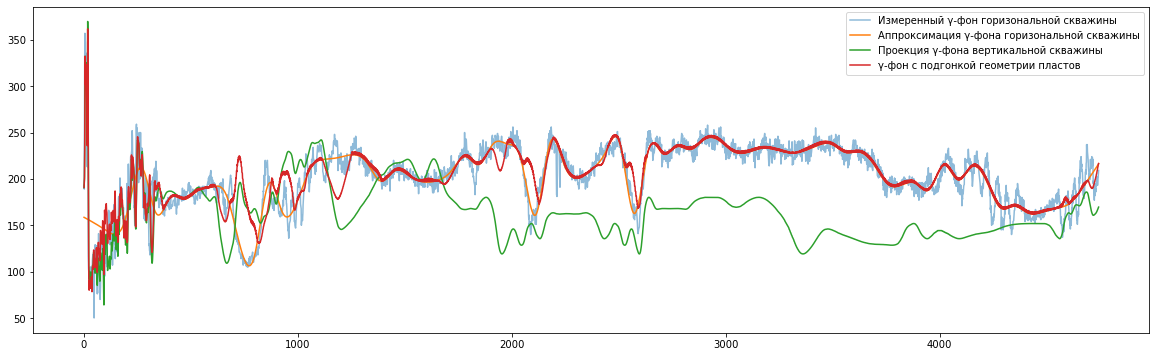

In [352]:
# TO DELETE
sns_plot = sns.lineplot(data=df.Curve, alpha=0.5, label='Измеренный γ-фон горизональной скважины')
sns_plot = sns.lineplot(data=df.Filtered_Curve, label='Аппроксимация γ-фона горизональной скважины')
sns_plot = sns.lineplot(data=df.Null_Projection, label='Проекция γ-фона вертикальной скважины')
sns_plot = sns.lineplot(data=df.fitted_curve, label='γ-фон с подгонкой геометрии пластов');

In [175]:
# curve_interpolator(horizontal_well.Depth) + horizontal_well['bias'].values

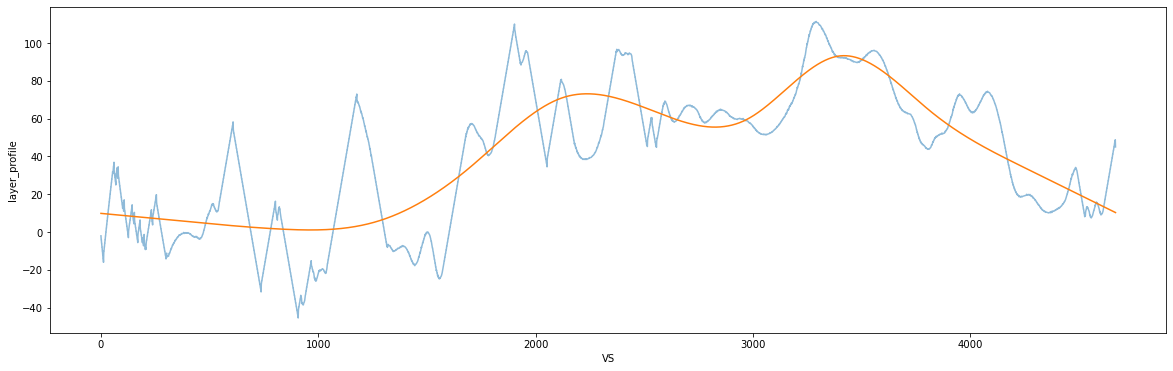

In [355]:
# Итоговый профиль

x = df.VS
y = df.layer_profile
# дополнительное сглаживание
spline_estimator = get_natural_cubic_spline_model(x,
                                                  y,
                                                  minval=min(x),
                                                  maxval=max(x),
                                                  n_knots=10)
yhat = spline_estimator.predict(x)
sns_plot = sns.lineplot(x=x, y=y, alpha=0.5, label='Геометрия по модели')
sns_plot = sns.lineplot(x=x, y=yhat, label='Сглаженная геометрия')

# fig = sns_plot.get_figure()
# fig.savefig("profile.png")

Соответственно, чтобы получить поведение слоев, остается прибавить полученное смещение к соответствующим точкам глубин (визуализация в процессе)

Выводы и дальнейшие действия: 
- Полученная модель достаточно грубо описывает поведение пластов, характеризующееся резкими пиками, что не соответствует реальным законам формирования пластов
- Логично попробовать использовать описание поведения пластов с помощью кривых Безье, как распространенную технику, используемую в моделировании земной поверхности 
- Следует оптимизировать ручную настройку диапазона подгонки, которая также способствует искажению результатов
- Возможно лучшему результату поспособствует замена фиксированного семплирования кривой на размеченные семплы фона, соответствующего конкретному виду земных пород
- Также немаловажно проведение анализа и фильтрации шумовой составляющей фона горизонтальной скважины
- К сожалению не удалось подобрать технику визуализации для построения кривой γ-фона ортогонально к кривой глубин (график из презентации)

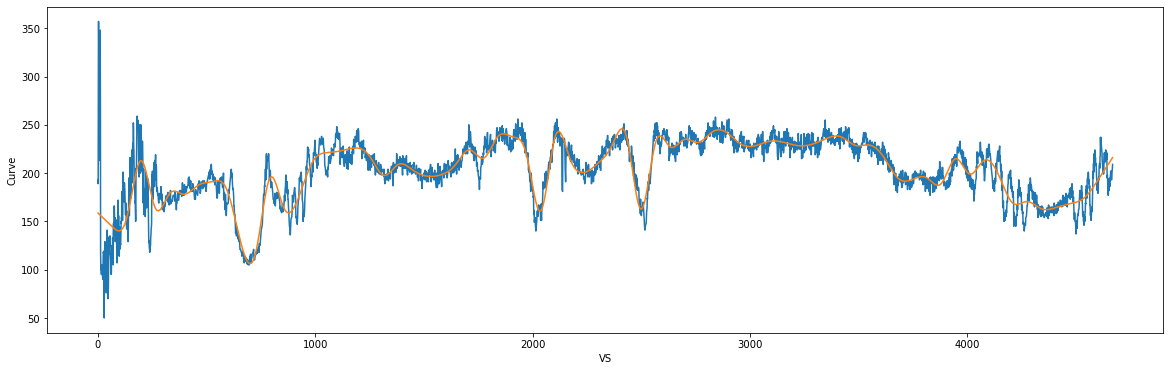

In [334]:
# Тест сглаживания изначальной кривой фона горизональной скважины
x = horizontal_well.VS
y = horizontal_well.Curve
spline_estimator = get_natural_cubic_spline_model(x,
                                                  y,
                                                  minval=min(x),
                                                  maxval=max(x),
                                                  n_knots=70)

yhat = spline_estimator.predict(x)
sns.lineplot(x, y)
sns.lineplot(x, yhat);

In [356]:
# tops.TopName.values
# TA = tops.loc[tops['TopName']=="TA"].Depth.values[0] # 3216.0
# TZ = tops.loc[tops['TopName']=="TZ"].Depth.values[0] # 3234.0
# TB = tops.loc[tops['TopName']=="TB"].Depth.values[0] # 3252.50
# Three_Lick_Bed= tops.loc[tops['TopName']=="Three_Lick_Bed"].Depth.values[0] # 3259.0
# Bottom_hrz = tops.loc[tops['TopName']=="Bottom_hrz"].Depth.values[0] # 3303.78
# vertical_well.loc[vertical_well['Depth']==TB]

Другие подходы, не получившие удовлетворительных результатов

Изначально предполагалось решение, построенное на гипотезе о представлении сдвига слоев, как разности глубин на основе соответствия заданного паттерна γ-коротажа в вертикальном колодце. 
Таким образом решение может быть сведено к выбору соответствующего алгоритма, поиска паттернов по заданной области.

Для этого был проведен поиск и тестирование различных подходов к матчингу временных рядов, такие как dtw, кросс-корреляция, корреляция пирсона, рекурсивный анализ (RQA)

Далее - описание подхода с помощью библиотеки [stumpy](https://stumpy.readthedocs.io/en/latest/Tutorial_STUMPY_Basics.html), основанной на оптимизированном расчете матриц профиля расстояний для поиска схожего сегмента (или нескольких) временного ряда по заданному паттерну. Stumpy - достаточно мощный и быстрый инструмент для поиска паттернов, однако для данной задачи он слабо применим - так как существует высокая вероятность ложной детекции отдаленных схожих участков в виду неточных границ поиска и наличия шума.

При данном подходе модель получает неконсистентна, её поведение сильно притянуто к конкретному заданному паттерну 

**Демо (stumpy)**

In [357]:
horizontal_window = horizontal_well.Curve[10:20]
vertical_window = vertical_well.Curve[0:30]
vert_well = vertical_well.Curve
distance_profile = stumpy.core.mass(horizontal_window, vertical_window)

In [358]:
# вывод индекса, соответствующего
idx = np.argmin(distance_profile)

print(f"The nearest neighbor to `horisontal window` is located at index {idx} in `vertical`")

The nearest neighbor to `horisontal window` is located at index 8 in `vertical`


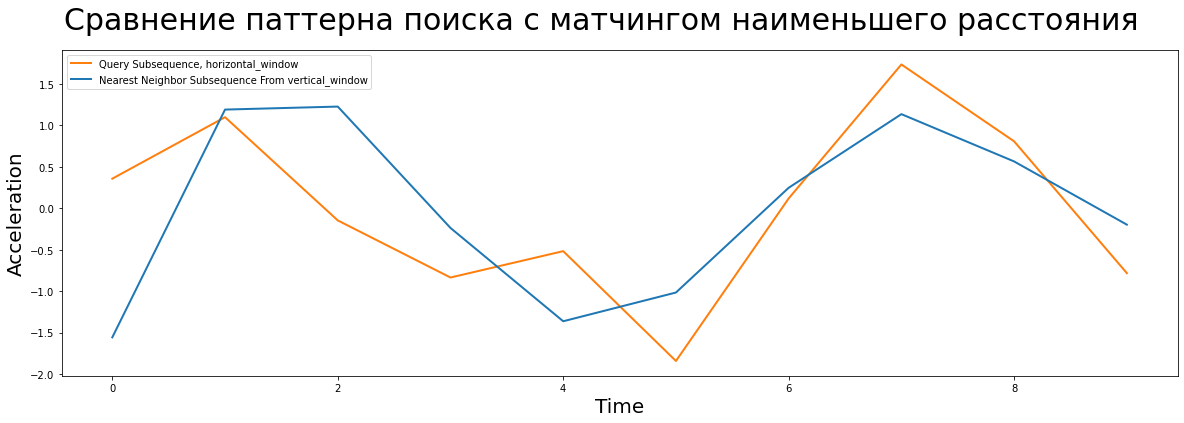

In [359]:
# Since MASS computes z-normalized Euclidean distances, 
# we should z-normalize our subsequences before plotting
H_z_norm = stumpy.core.z_norm(horizontal_window.values)
W_z_norm = stumpy.core.z_norm(vertical_window.values[idx:idx+len(horizontal_window)])

plt.suptitle('Сравнение паттерна поиска с матчингом наименьшего расстояния', fontsize='30')
plt.xlabel('Time', fontsize ='20')
plt.ylabel('Acceleration', fontsize='20')
plt.plot(H_z_norm, lw=2, color="C1", label="Query Subsequence, horizontal_window")
plt.plot(W_z_norm, lw=2, label="Nearest Neighbor Subsequence From vertical_window")
plt.legend()
plt.show()

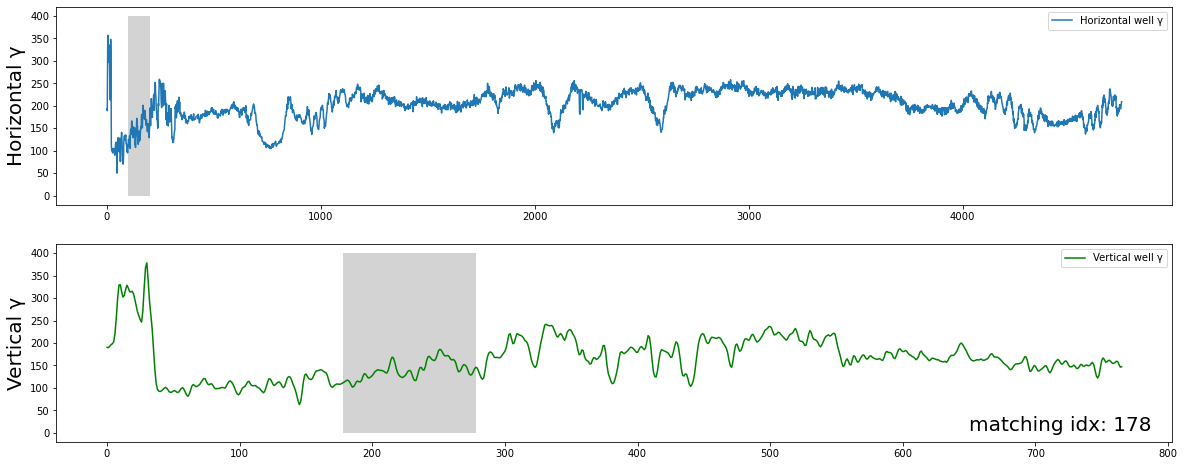

In [70]:
# Область сверху - паттерн слоев для поиска из горизонального колодца
# Область снизу - соответствующий е
change_plot_size(20, 8, plt)
window = 100
m = 100 # левая граница окна
horizontal_window = horizontal_well.Curve[m:window+m]
vert_well = vertical_well.Curve[:410]
distance_profile = stumpy.core.mass(Q=horizontal_window, T=vert_well)
idx = np.argmin(distance_profile)

fig, axs = plt.subplots(2, sharex=False) # gridspec_kw={'hspace': 0}
axs[0].plot(horizontal_well.Curve, label='Horizontal well γ')
axs[0].set_ylabel('Horizontal γ', fontsize='20')
rect = Rectangle((m, 0), window, 400, facecolor='lightgrey')
axs[0].add_patch(rect)
# axs[1].set_xlabel('n', fontsize ='20')
axs[0].legend()

axs[1].plot(vertical_well.Curve, label='Vertical well γ', c='g')
axs[1].set_ylabel('Vertical γ', fontsize='20')
rect = Rectangle((idx, 0), window, 400, facecolor='lightgrey')
plt.text(650, 3.6, f'matching idx: {idx}', color="black", fontsize=20)
axs[1].add_patch(rect)
axs[1].legend()


plt.show()

Пример реализации на stumpy

In [362]:
df.head()

,MD,Depth,VS,Curve,Null_Projection,Filtered_Curve,fitted_curve,layer_profile
0,3091,3069.23,0.00,193.0,190.691996,158.547656,190.691996,-2.0
1,3092,3070.05,0.57,189.0,196.379813,158.425313,197.379813,-3.0
2,3093,3070.86,1.14,279.0,200.103098,158.302971,202.103098,-4.0
3,3094,3071.68,1.72,331.0,232.695996,158.178482,230.695996,-4.0
4,3095,3072.50,2.30,357.0,300.095837,158.053994,299.095837,-5.0


In [377]:
# Не корректное решение
def get_layer_profile_by_matching_patterns(horizontal_well: pd.DataFrame,
                                            window: int = 100,
                                            stride: int = 100,
                                            start_pos: int = 0
                                           ):
    
    horizontal_curve =  horizontal_well.Filtered_Curve
    vertical_curve = horizontal_well.Null_Projection
    
    # список начальных индексов окон
    windows_idx = np.arange(start_pos, len(horizontal_curve)-window, stride)
    depth_shift = 0  # оценка глубины пластов с учетом смещения
    distance = [] # расстояние (x)
    layer_profile = [] # смещение по пластам (y)
    vd_idx = 0
    idx = 0
    idx_pred = 0
    
    # проход по индексам с учетом страйда
    for i in windows_idx:
        cur_hor_window = horizontal_well.iloc[i:i+window].Curve
        # поиск паттерна в диапазоне
        # print(cur_hor_window)
        # расчет расстояний
        distance_profile = stumpy.core.mass(Q=cur_hor_window, T=vertical_curve)
        idx = np.argmin(distance_profile)
        # print(f"The nearest neighbor to horisontal window is located at index {idx} in vertical")
        # позиционирование глубины соответствующей индексу окна
        current_hor_depth = horizontal_well.Depth.iloc[i]
        # глубина, которой соответствует паттерн
        matching_depth = horizontal_well.iloc[idx].Depth
        depth_shift = current_hor_depth - matching_depth
        # расстояние (x)
        distance.append(horizontal_well.VS.iloc[i])
        # изменение глубины     
        layer_profile.append(depth_shift)
        
    return distance, layer_profile

In [378]:
distance, layer_profile = get_layer_profile_by_matching_patterns(df)

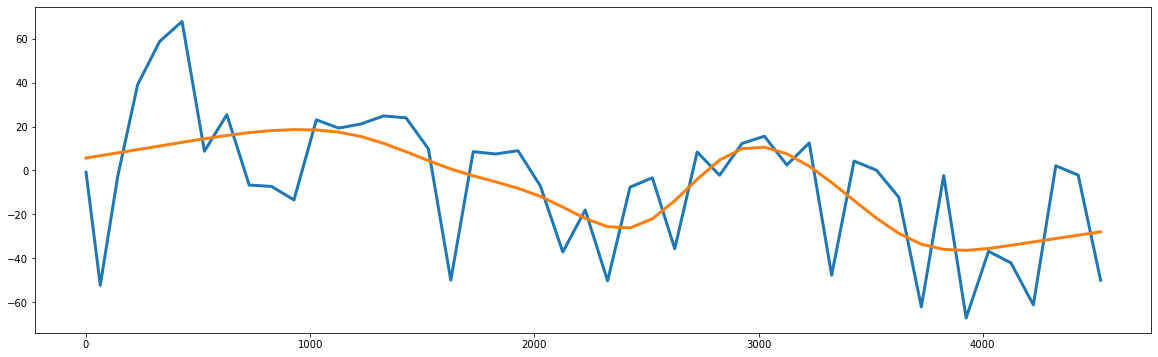

In [379]:
x = np.array(distance)
y = np.array(layer_profile)
spline_estimator = get_natural_cubic_spline_model(x,
                                                  y,
                                                  minval=min(x),
                                                  maxval=max(x),
                                                  n_knots=10)
yhat = spline_estimator.predict(x)

sns.lineplot(x, y, linewidth=3)
sns.lineplot(x, yhat, linewidth=3);

# sns.lineplot(x=distance, y=y2);

In [ ]:
################################
# генерация изображений в gif
# для анализа поведения модели
################################

# from datetime import datetime

# img_counter = 0
# fpath = 'pics/'
# horizontal_curve = horizontal_well[:201]
# vert_well = vertical_well.Curve[:410]
# window = 100
# stride = 1
# m = 0 # левая граница окна

# windows_idx = np.arange(m, len(horizontal_curve)-window, stride)
# for i in windows_idx:
#     img_counter +=1
#     horizontal_window = horizontal_well.Curve[m+i:window+i+m]

#     distance_profile = stumpy.core.mass(Q=horizontal_window, T=vert_well)
#     idx = np.argmin(distance_profile)

#     fig, axs = plt.subplots(2, sharex=False) # gridspec_kw={'hspace': 0}
#     axs[0].plot(horizontal_well.Curve, label='Horizontal well γ')
#     axs[0].set_ylabel('Horizontal γ', fontsize='20')
#     rect = Rectangle((i, 0), window, 400, facecolor='lightgrey')
#     axs[0].add_patch(rect)
#     plt.text(580, 540, f'window = {window}, index = {i}', color="black", fontsize=20)
#     axs[0].legend()

#     axs[1].plot(vertical_well.Curve, label='Vertical well γ', c='g')
#     axs[1].set_ylabel('Vertical γ', fontsize='20')
#     rect = Rectangle((idx, 0), window, 400, facecolor='lightgrey')
#     plt.text(650, 3.6, f'matching idx: {idx}', color="black", fontsize=20)
#     axs[1].add_patch(rect)
#     axs[1].legend()
    
#     fn_gen = f"{fpath}pic{str(datetime.now()).replace(':', '-')}.jpg"
#     plt.savefig(fn_gen, dpi=100)

In [ ]:
# from __future__ import division
# import glob
# from PIL import Image

# target = './pics/*.jpg'
# output = './pics/output.gif'

# images = []
# basewidth = 640

# # Create images list
# for filename in glob.glob(target):
#     img = Image.open(filename)
#     wpercent = (basewidth / float(img.size[0]))
#     hsize = int((float(img.size[1]) * float(wpercent)))
#     img = img.resize((basewidth, hsize), Image.ANTIALIAS)

#     images.append(img)
    
# images[0].save(output, format='GIF', append_images=images[1:], save_all=True, duration=3, loop=0)